Домашнее задание
<br>Сравнение трех разобранных алгоритмов бустинга и подбор гиперпараметров для получения лучшего качества.
<br>Цель: использовать любой датасет для задачи классификации: https://archive.ics.uci.edu/ml/datasets

In [143]:
import pandas as pd
import numpy as np
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

# Подготовка данных

In [127]:
# Divorce Predictors data set Data Set 
data_path = '/Users/katush/Documents/Otus/ML/L13-Gradient boosting/divorce/'
data = pd.read_csv(data_path+'divorce.csv', sep=';')
data.shape

(170, 55)

In [130]:
features = data.columns[:-1]
target = ['Class']

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

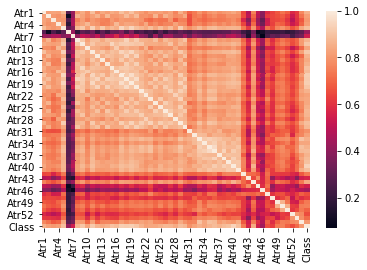

In [134]:
sns.heatmap(data.corr())

# Качество моделей из коробки

In [185]:
p = []
rocs = {}
for model in [GradientBoostingClassifier(), XGBClassifier(), CatBoostClassifier()]:
    m = model
    try:
        m.fit(X_train, y_train, silent=True)
    except:
        m.fit(X_train, y_train)
    prediction = m.predict(X_test)
    name = m.__class__.__name__
    print(name)
    roc = roc_auc_score(y_test, prediction)
    rocs[f'{name} out of box'] = roc
    print(roc)
    p.append(m.predict_proba(X_test))

GradientBoostingClassifier
0.9649014778325125
XGBClassifier
0.9827586206896552
CatBoostClassifier
0.9827586206896552


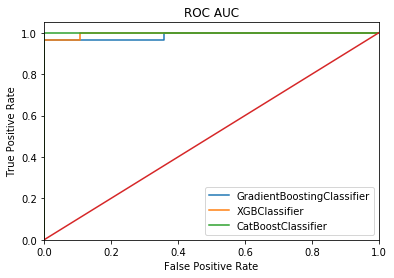

In [187]:
fpr, tpr, thresholds = roc_curve(y_test, p[0][:, 1])
plt.plot(fpr, tpr, label='GradientBoostingClassifier')
fpr, tpr, thresholds = roc_curve(y_test, p[1][:, 1])
plt.plot(fpr, tpr, label='XGBClassifier')
fpr, tpr, thresholds = roc_curve(y_test, p[2][:, 1])
plt.plot(fpr, tpr, label='CatBoostClassifier')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.legend()

# Подбор параметров бустинга

In [170]:
xgb_params = {'n_estimators': 100, 'booster': 'gbtree', 'max_depth': 3, 'eta': 0.1, 'silent': True, 'nthread': 4}
catb_params = {'n_estimators': 100, 'depth': 3, 'learning_rate': 0.1, 'thread_count': 4}
skl_params = {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

xgb_time = list()
catb_time = list()
skl_time = list()

n_runs = 100

for i in range(n_runs):
    t = time.time()
    xgb = XGBClassifier(**xgb_params).fit(X_train, y_train)
    elapsed = time.time() - t
    xgb_time.append(elapsed)
    
    t = time.time()
    catb = CatBoostClassifier(**catb_params).fit(X_train, y_train, silent=True)
    elapsed = time.time() - t
    catb_time.append(elapsed)
    
    t = time.time()
    skl = GradientBoostingClassifier(**skl_params).fit(X_train, y_train)
    elapsed = time.time() - t
    skl_time.append(elapsed)

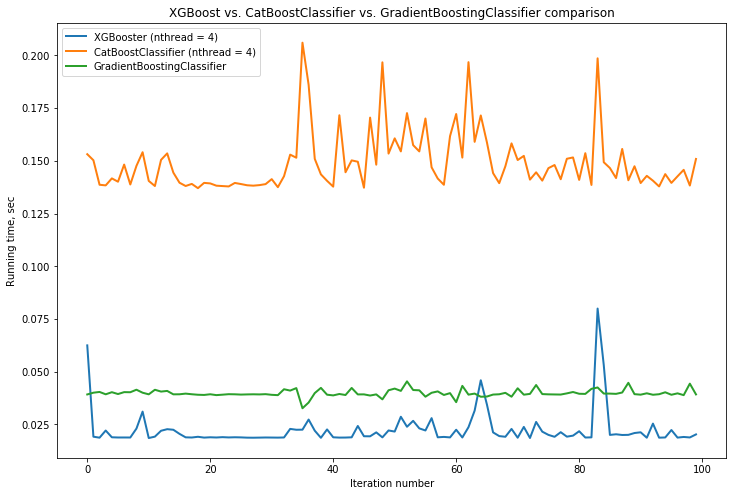

In [171]:
xgb_mean = sum(xgb_time) / n_runs
catb_mean = sum(catb_time) / n_runs
skl_mean = sum(skl_time) / n_runs

plt.figure(figsize=(12, 8))
plt.plot(xgb_time, label='XGBooster (nthread = 4)', lw=2)
plt.plot(catb_time, label='CatBoostClassifier (nthread = 4)', lw=2)
plt.plot(skl_time, label='GradientBoostingClassifier', lw=2)
plt.legend(loc='best')
plt.xlabel('Iteration number')
plt.ylabel('Running time, sec')
plt.title('XGBoost vs. CatBoostClassifier vs. GradientBoostingClassifier comparison')
plt.show()

In [175]:
print('MEAN TIME:')
print(xgb_mean, 'XGBooster')
print(catb_mean, 'CatBoostClassifier')
print(skl_mean, 'GradientBoostingClassifier')

MEAN TIME:
0.02250999689102173 XGBooster
0.14928473234176637 CatBoostClassifier
0.03981911659240723 GradientBoostingClassifier


### _XGBooster performs faster than others when using 4 threads_

In [188]:
name = 'XGBClassifier'
params = {'booster': ['gbtree', 'gblinear', 'dart'],
          'learning_rate': [0.05, 0.10, 0.15, 0.20],
          'max_depth': [3, 4, 5, 6],
          'min_child_weight': [1, 3, 5, 7 ],
          'gamma': [0.0, 0.1, 0.2],
          'colsample_bytree': [0.3, 0.4, 0.5]}

model = XGBClassifier(silent=True, nthread=4)
grid = GridSearchCV(model, param_grid=params)
grid.fit(X_train, y_train)
prediction = grid.predict(X_test)
roc = roc_auc_score(y_test, prediction)
print(roc)
rocs['GridSearched XGB'] = roc

0.9827586206896552


In [190]:
rocs

{'GradientBoostingClassifier out of box': 0.9649014778325125,
 'XGBClassifier out of box': 0.9827586206896552,
 'CatBoostClassifier out of box': 0.9827586206896552,
 'GridSearched XGB': 0.9827586206896552}

In [189]:
grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.0,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, verbosity=1)

### _XGBClassifier shows one of the highest roc-auc-score 0.9827586206896552 in the shortest time 0.02250999689102173_